# Old version of membership inference attack (MIA)
## Keenan Hom
The original choice for MIA is here: https://arxiv.org/pdf/2102.05429. Because there was no provided code, I attempted to reproduce it from the descriptions in the paper, but was not able to achieve the same success that the authors did. In addition, this architecture is poorly suited to our project's needs because this attack method only works on a GNN trained on a single large graph, but all of our datasets are multi-graph.

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
# Add the project root (the folder containing "main") to sys.path
sys.path.append('..')
from membership_inference_attack.ml_util import train_model

In [48]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import PPI
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from ml_util import train_model, train_model_single_graph, get_accuracy

In [49]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [63]:
def cora_transform(data):
    '''
    Transform Cora data. Performs the following operations:
    - Turn y labels into one-hot vectors
    '''
    data.y = torch.Tensor(OneHotEncoder().fit_transform(data.y.reshape(-1,1)).todense())
    return data    

In [75]:
class GATPPIModel(nn.Module):
    def __init__(self, num_feat, num_classes):
        super().__init__()
        
        self.gat1 = gnn.conv.GATConv(num_feat, 32, heads=4, dropout=0.)
        self.gat2 = gnn.conv.GATConv(32 * 4, 128, heads=2, dropout=0.)
        self.gat3 = gnn.conv.GATConv(128 * 2, 128, heads=2, dropout=0.)
        self.gat4 = gnn.conv.GATConv(128 * 2, num_classes, heads=1, dropout=0)
        
        self.relu = nn.ReLU()
        
    
    def forward(self, x, edge_index):
        out1 = self.gat1(x, edge_index).relu()
        out2 = self.gat2(out1, edge_index).relu()
        out3 = self.gat3(out2, edge_index).relu()
        out4 = self.gat4(out3, edge_index)
        
        return out4
    
    
class GenericAttackModel(nn.Module):
    def __init__(self, num_feat):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_feat, 128),
#             nn.Dropout(0.5),
            nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 128),
#             nn.Dropout(0.5),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(128, 2),
#             nn.Dropout(0.5)
        )
        
        
    def forward(self, x):
        return self.layers(x)
    
    
class GenericDataset(Dataset):
    def __init__(self, x, y):
        '''
        Generic dataset for training PyTorch models/
        
        x should be shape (num_samples, num_features)
        y should be shape (num_samples, num_classes) and be one-hot encoded
        '''
        self.x = x
        self.y = y
        
        
    def __len__(self):
        return self.x.shape[0]
    
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [76]:
# dataset = Planetoid(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/', name='Citeseer', split='full', transform=cora_transform)
dataset = PPI(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/PPI', split='train')

d = dataset[18]
t_data, s_data = target_shadow_split(d)

In [77]:
lr = 0.003
epochs = 200
t_model = GATPPIModel(num_feat=50, num_classes=121).to(DEVICE)
optimizer = optim.Adam(t_model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

train_model_single_graph(t_model, optimizer, t_data, loss_fn, epochs, device=DEVICE)
t_model.eval()

Learning rate: 0.003
No learning rate scheduling!
Using device: cuda:0

-----Epoch 1/200-----
Loss: 0.697044849395752 (0.011s), train acc: 0.000, val loss: 0.669, val acc: 0.000

-----Epoch 2/200-----
Loss: 0.6698315143585205 (0.006s), train acc: 0.000, val loss: 0.633, val acc: 0.000

-----Epoch 3/200-----
Loss: 0.6351044178009033 (0.005s), train acc: 0.000, val loss: 0.583, val acc: 0.000

-----Epoch 4/200-----
Loss: 0.5875763297080994 (0.005s), train acc: 0.000, val loss: 0.569, val acc: 0.000

-----Epoch 5/200-----
Loss: 0.5781262516975403 (0.005s), train acc: 0.000, val loss: 0.566, val acc: 0.000

-----Epoch 6/200-----
Loss: 0.5757008194923401 (0.005s), train acc: 0.000, val loss: 0.548, val acc: 0.000

-----Epoch 7/200-----
Loss: 0.5555394291877747 (0.005s), train acc: 0.000, val loss: 0.543, val acc: 0.000

-----Epoch 8/200-----
Loss: 0.5488331317901611 (0.005s), train acc: 0.000, val loss: 0.548, val acc: 0.000

-----Epoch 9/200-----
Loss: 0.5520561933517456 (0.005s), train ac

GATPPIModel(
  (gat1): GATConv(50, 32, heads=4)
  (gat2): GATConv(128, 128, heads=2)
  (gat3): GATConv(256, 128, heads=2)
  (gat4): GATConv(256, 121, heads=1)
  (relu): ReLU()
)

In [78]:
lr = 0.003
epochs = 200
s_model = GATPPIModel(num_feat=50, num_classes=121).to(DEVICE)
optimizer = optim.Adam(s_model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

train_model_single_graph(s_model, optimizer, s_data, loss_fn, epochs, device=DEVICE)
s_model.eval()

Learning rate: 0.003
No learning rate scheduling!
Using device: cuda:0

-----Epoch 1/200-----
Loss: 0.6930162906646729 (0.006s), train acc: 0.000, val loss: 0.662, val acc: 0.000

-----Epoch 2/200-----
Loss: 0.663419783115387 (0.005s), train acc: 0.000, val loss: 0.618, val acc: 0.000

-----Epoch 3/200-----
Loss: 0.6211495399475098 (0.005s), train acc: 0.000, val loss: 0.571, val acc: 0.000

-----Epoch 4/200-----
Loss: 0.5798873901367188 (0.005s), train acc: 0.000, val loss: 0.580, val acc: 0.000

-----Epoch 5/200-----
Loss: 0.5964093208312988 (0.005s), train acc: 0.000, val loss: 0.551, val acc: 0.000

-----Epoch 6/200-----
Loss: 0.565484881401062 (0.005s), train acc: 0.000, val loss: 0.538, val acc: 0.000

-----Epoch 7/200-----
Loss: 0.5496479868888855 (0.005s), train acc: 0.000, val loss: 0.544, val acc: 0.000

-----Epoch 8/200-----
Loss: 0.5528281331062317 (0.005s), train acc: 0.000, val loss: 0.548, val acc: 0.000

-----Epoch 9/200-----
Loss: 0.5567325949668884 (0.005s), train acc

GATPPIModel(
  (gat1): GATConv(50, 32, heads=4)
  (gat2): GATConv(128, 128, heads=2)
  (gat3): GATConv(256, 128, heads=2)
  (gat4): GATConv(256, 121, heads=1)
  (relu): ReLU()
)

In [79]:
attack_x, attack_y = create_attack_dataset(s_model, s_data)
att_dataset = GenericDataset(attack_x, attack_y)
lr = 0.001
epochs = 500
batch_size = 32
att_model = GenericAttackModel(num_feat=121).to(DEVICE)
optimizer = optim.Adam(att_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_model(att_model, optimizer, att_dataset, loss_fn, epochs, batch_size, device=DEVICE)
att_model.eval()

Learning rate: 0.001
No learning rate scheduling!
Training for 500 epochs, with batch size=32
Using device: cuda:0

-----Epoch 1/500-----
Batch 10/50, loss: 0.6936513245105743 (0.010s), train acc: 0.503
Batch 20/50, loss: 0.691608989238739 (0.010s), train acc: 0.527
Batch 30/50, loss: 0.6950693368911743 (0.010s), train acc: 0.512
Batch 40/50, loss: 0.6946593999862671 (0.010s), train acc: 0.507
Batch 50/50, loss: 0.6941666007041931 (0.010s), train acc: 0.496

-----Epoch 2/500-----
Batch 10/50, loss: 0.6928510546684266 (0.009s), train acc: 0.531
Batch 20/50, loss: 0.6946166932582856 (0.009s), train acc: 0.509
Batch 30/50, loss: 0.6935193419456482 (0.010s), train acc: 0.507
Batch 40/50, loss: 0.6920548856258393 (0.010s), train acc: 0.513
Batch 50/50, loss: 0.696242380142212 (0.010s), train acc: 0.499

-----Epoch 3/500-----
Batch 10/50, loss: 0.6933790266513824 (0.009s), train acc: 0.494
Batch 20/50, loss: 0.692911809682846 (0.009s), train acc: 0.503
Batch 30/50, loss: 0.6944271147251129 (

GenericAttackModel(
  (layers): Sequential(
    (0): Linear(in_features=121, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [80]:
att_model.eval()
t_x, t_y = create_attack_dataset(t_model, t_data)

pred = att_model(t_x.to(DEVICE)).detach().cpu()
get_accuracy(pred, t_y)

0.5041113219481341

In [23]:
idx = np.where(np.argmax(t_y, axis=1) == 0)[0]
get_accuracy(pred[idx], t_y[idx])

0.4675480769230769

In [24]:
idx = np.where(np.argmax(t_y, axis=1) == 1)[0]
get_accuracy(pred[idx], t_y[idx])

0.7496991576413959

In [25]:
from matplotlib import pyplot as plt

<BarContainer object of 6 artists>

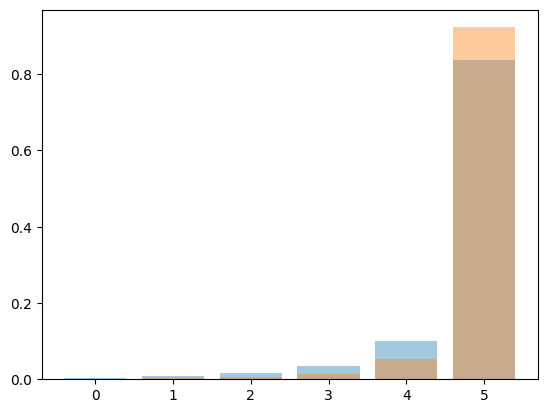

In [15]:
plt.bar(list(range(6)), t_x[t_y.argmin(dim=1).to(bool)].mean(dim=0), alpha=0.4)
plt.bar(list(range(6)), t_x[t_y.argmax(dim=1).to(bool)].mean(dim=0), alpha=0.4)

<BarContainer object of 6 artists>

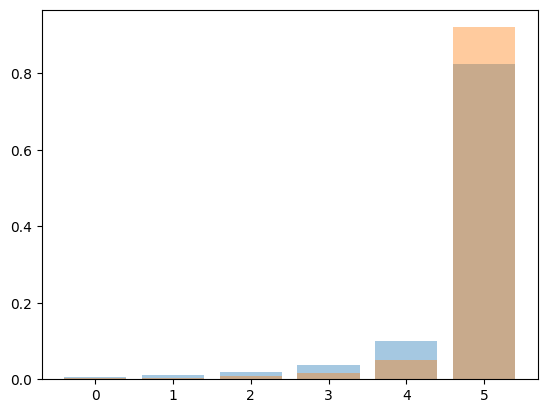

In [16]:
plt.bar(list(range(6)), attack_x[attack_y.argmin(dim=1).to(bool)].mean(dim=0), alpha=0.4)
plt.bar(list(range(6)), attack_x[attack_y.argmax(dim=1).to(bool)].mean(dim=0), alpha=0.4)

In [26]:
query_zero_hop(t_model, s_data.x[0])

tensor([[-1.6288, -1.5556,  0.2882,  5.3236, -1.2754,  0.3285]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
query_zero_hop(s_model, s_data.x[0])

tensor([[-2.0381, -2.7032, -1.2279,  4.5965, -1.2803, -1.0144]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
query_zero_hop(t_model, s_data.x[0])

tensor([[-1.6288, -1.5556,  0.2882,  5.3236, -1.2754,  0.3285]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [32]:
s_data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327, 6], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [46]:
for x in s_data.x:
    t_pred = query_zero_hop(t_model, x).softmax(dim=1)[0].log()
    s_pred = query_zero_hop(s_model, x).softmax(dim=1)[0].log()
#     print(s_pred.softmax(dim=1)[0])
#     print(s_pred)
    print(F.kl_div(t_pred, s_pred, log_target=True))

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7845e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0251, device='cuda

In [19]:
att_model(t_x.to(DEVICE)).detach().cpu()

tensor([[-0.2024,  0.2694],
        [-0.2251,  0.2920],
        [ 1.3049, -1.1046],
        ...,
        [-0.2102,  0.2770],
        [-0.1613,  0.2264],
        [ 0.3046, -0.1908]])

In [20]:
count = 0
for i in range(t_data.num_nodes):
    
    if t_data.train_mask[i]:
        pred = query_zero_hop(t_model, t_data.x[i]).detach().cpu()
        print(pred, 1)
    elif t_data.test_mask[i]:
        pred = query_zero_hop(t_model, t_data.x[i]).detach().cpu()
        print(pred, 0)
count

tensor([[-0.3306,  6.5233,  0.3790, -5.2127, -0.0700, -1.2676]]) 0
tensor([[-4.2230, -2.8926, -2.3202, -0.6136, -1.0923,  9.0295]]) 1
tensor([[-2.4567,  1.2455, -0.1968, -0.6522, -0.1249,  1.4294]]) 0
tensor([[-0.1942,  6.4990,  1.1117, -1.6230, -1.8155, -2.8304]]) 1
tensor([[-0.1924,  1.3156,  5.0560, -0.7706, -1.6254, -0.9846]]) 0
tensor([[ 0.0217, -4.1570, -5.0231,  3.4691,  3.9772, -0.7018]]) 0
tensor([[ 3.1671,  2.4182,  5.5301, -2.0429, -3.6690, -4.2726]]) 0
tensor([[-0.0350,  8.1872,  1.3754, -1.5269, -2.2231, -3.7270]]) 0
tensor([[-1.5291,  1.2116,  4.3174,  1.7053, -1.9073,  0.0722]]) 0
tensor([[-1.4291, -0.4917,  7.3205,  2.4674, -1.2470, -2.4339]]) 1
tensor([[-2.8103,  1.2664, -0.1583,  0.6598,  2.2892, -0.2350]]) 1
tensor([[ 3.9910,  2.6695, -1.2225, -0.9036, -1.0643, -5.1664]]) 1
tensor([[-2.5793, -2.8477, -2.4662, -0.0145, -0.1930,  7.0797]]) 0
tensor([[-0.2909,  1.8908,  3.4079,  2.4875, -1.9633, -2.7896]]) 0
tensor([[-1.2980, -0.4327, -1.5348, -0.6909,  0.2168,  2.6888]

0

In [21]:
t_data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327, 6], train_mask=[3327], val_mask=[3327], test_mask=[3327])